# FREE DIVING INTO FOOD FACTS

## Applied data anaylsis - Course Project 

In this notebook , we try to clean and prepare the dataset to answer the 4th question proposed in the readme.   
**How do ingredients or categories influence the selected nutrition scores?** 

## Imports needed 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import re
import sqlite3
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Loading the dataset 

In [ ]:
food_facts_df = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t',low_memory=False)

In [ ]:
print('There are {:,} rows '.format(food_facts_df.shape[0]) + 'and {} columns in our data'.format(food_facts_df.shape[1]))


In [ ]:
food_facts_df.head()

## Data Cleaning 

The code for each row seems to be unique, let's see if it's the case. 

In [ ]:
print("We have {} rows in the dataset".format(food_facts_df.shape[0]))
print("We have {} different code in the dataset".format((np.unique(food_facts_df['code']).shape[0])))

Indeed, the code is unique for each row of the dataset except for a small number of duplicates. Let's check that. 

In [ ]:
number_duplicates=food_facts_df['code'].duplicated()
print("We have {} duplicated code".format(number_duplicates.value_counts()[1]))

Let's start by dropping these duplicated rows:

In [7]:
food_facts_df.drop_duplicates(subset=['code'],inplace=True)
print("We have {} rows in the dataset after dropping the duplicates.".format(food_facts_df.shape[0]))

We have 1029238 rows in the dataset after dropping the duplicates.


Great! We have now a unique code for each row. We can set the code as an index for the whole dataset.

In [8]:
#lets fix the code as indes 
food_facts_df.set_index('code', inplace=True)

In [9]:
food_facts_df.head(5)

,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,NaN,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see from the 5 first rows in the dataset, the data is messy and has a huge number of NaNs.We need a huge data cleaning.

Before dealing with NaNs, let's try to see what are the different columns of the dataset 

In [10]:
food_facts_df.columns

Index(['url', 'creator', 'created_t', 'created_datetime', 'last_modified_t',
       'last_modified_datetime', 'product_name', 'generic_name', 'quantity',
       'packaging',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=174)

As we can see, each row of this dataset in created by an editor. This allows us to ask the following question:

### Can we trust Open Food Facts dataset?

The creators of each row of the dataset are provided as a field. Let's try to see who are the main contributors to this data before starting to analyze it.

In [11]:
## Computing the number of contributors
nb_contributors=food_facts_df['creator'].unique().shape[0]
print("We have overall {} contributors".format(nb_contributors))

We have overall 9514 contributors


Let's see how many contributions each creator has in the dataset

In [12]:
# Computing the contributions 
counts = food_facts_df['creator'].value_counts()
counts = counts.to_frame(name='counts')
counts['percentage'] = counts['counts']/food_facts_df.shape[0]

# Extracting only the top find and calculating the percentage of contribution
top_10 = round(sum(counts[0:10]['percentage']),2)*100
print("The 10 main", 'creators',"account for", top_10,"% of all contributions \n")
print(counts.head(10))

The 10 main creators account for 89.0 % of all contributions 

                            counts  percentage
kiliweb                     540476    0.525122
usda-ndb-import             169854    0.165029
openfoodfacts-contributors  116884    0.113564
date-limite-app              25144    0.024430
elcoco                       24829    0.024124
openfood-ch-import           11459    0.011133
sebleouf                     10140    0.009852
tacite                        8505    0.008263
tacinte                       5556    0.005398
waistline-app                 4467    0.004340


After googling these 5 main contributors we can easily identify them: 
* `kiliweb` represnets the YUKA app (a French app aiming to compare the products bases on different criterions)
* `usda` represnets United States Department of Agriculture 
* `openfoodfacts-contributors` a bench of 20 main contributors.
* `data-limite-app` food application available for ios and androids users. (French app)
* `Elcoco` also a food application (spanish app)
* `openfood-ch-import` seems to be openfood contributors from Switzerland

These 6 sources of contributions seem to be reliable since we can clearly understand where the data comes from.

In [13]:
#Getting the top 6
top5_cont=counts.head(6).index

In [14]:
food_facts_df=food_facts_df.loc[food_facts_df['creator'].isin([top5_cont[0],top5_cont[1],top5_cont[2],top5_cont[3],top5_cont[4],top5_cont[5]])]

In [15]:
print('There are {:,} rows '.format(food_facts_df.shape[0]) + 'and {} columns in our data'.format(food_facts_df.shape[1]))

There are 888,646 rows and 174 columns in our data


This dataset is provided with a text file describing the different fields as follows : 
- fields that end with _t are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
- fields that end with _datetime are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
- fields that end with _tags are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
- fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
- fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
- fields that end with _serving correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product


In [16]:
#checking the types for each feature
food_facts_df.dtypes

url                    object
creator                object
created_t               int64
created_datetime       object
last_modified_t         int64
                       ...   
choline_100g          float64
phylloquinone_100g    float64
beta-glucan_100g      float64
inositol_100g         float64
carnitine_100g        float64
Length: 174, dtype: object

We will exclude all non float features (i.e object). 

In [17]:
food_facts_df = food_facts_df.select_dtypes(include=[np.float])

In [18]:
food_facts_df.columns

Index(['cities', 'allergens_en', 'serving_quantity', 'no_nutriments',
       'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil', 'nova_group',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=117)

In [19]:
print('There are {:,} rows '.format(food_facts_df.shape[0]) + 'and {} columns left in our data'.format(food_facts_df.shape[1]))

There are 888,646 rows and 117 columns left in our data


Let us now analyze the level of completness for each editor

In [ ]:
food_facts_df=food_facts_df[food_facts_df['creator']!='kiliweb']


### Dealing with NaNs

Our dataset has a huge number of NaNs. Dropping all of them will lead to an empty data frame. 
As an efficient strategy to deal with these missing values, we will first count the number of NaNs from the dataset and then remove the features where the number of missing values exceeds a certain threshold. 

Let's count the number of nans for each feature: 

In [20]:
nutrition_facts_df=food_facts_df.copy()

In [21]:
NaNs_distribution_series=nutrition_facts_df.isnull().sum().sort_values()
NaNs_distribution_series

energy_100g            165091
proteins_100g          166341
fat_100g               168234
carbohydrates_100g     168364
sugars_100g            177824
                        ...  
-mead-acid_100g        888646
-erucic-acid_100g      888646
-nervonic-acid_100g    888646
-caprylic-acid_100g    888646
cities                 888646
Length: 117, dtype: int64

Let us visualize the distribution of NaNs in the dataset

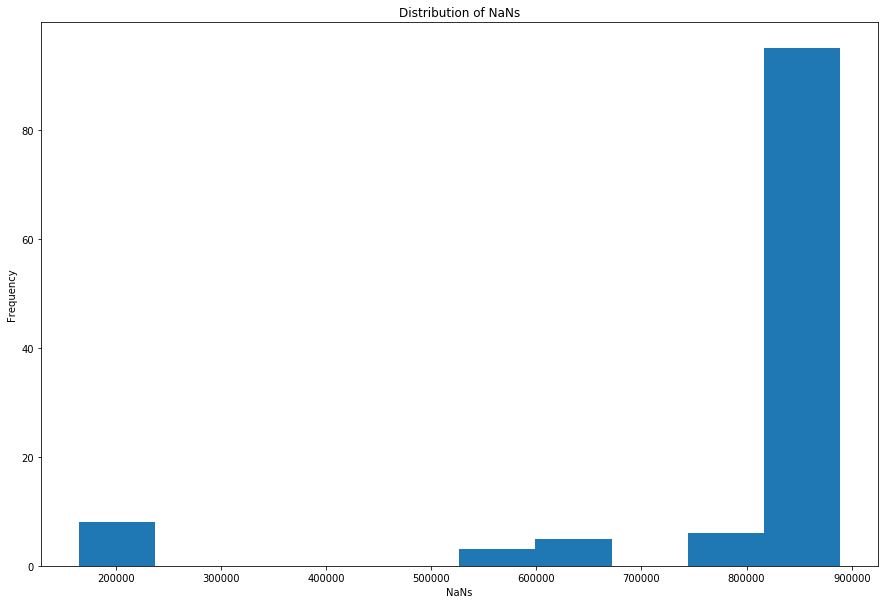

In [22]:
nutrition_facts_df.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

Many columns have a huge number of missing values(More than 85 columns with 350000 NaNs), let's try to remove some of them by playing with the threshold value.   
We will plot the new distribution of NaNs. Our main objective is to remove this huge peak of frequency visualized in the plot above.   
We tune the threshold with a trial and error to have a satisfactory result. 

In [23]:
nutrition_facts_thresh_df = nutrition_facts_df.dropna(axis=1, thresh= len(nutrition_facts_df)*0.2,how='all')
nutrition_facts_thresh_df = nutrition_facts_thresh_df.dropna(axis=0, how='all')

print('There are now {:,} rows '.format(nutrition_facts_thresh_df.shape[0]) + 'and {} columns left in our data'.format(nutrition_facts_thresh_df.shape[1]))

There are now 738,255 rows and 16 columns left in our data


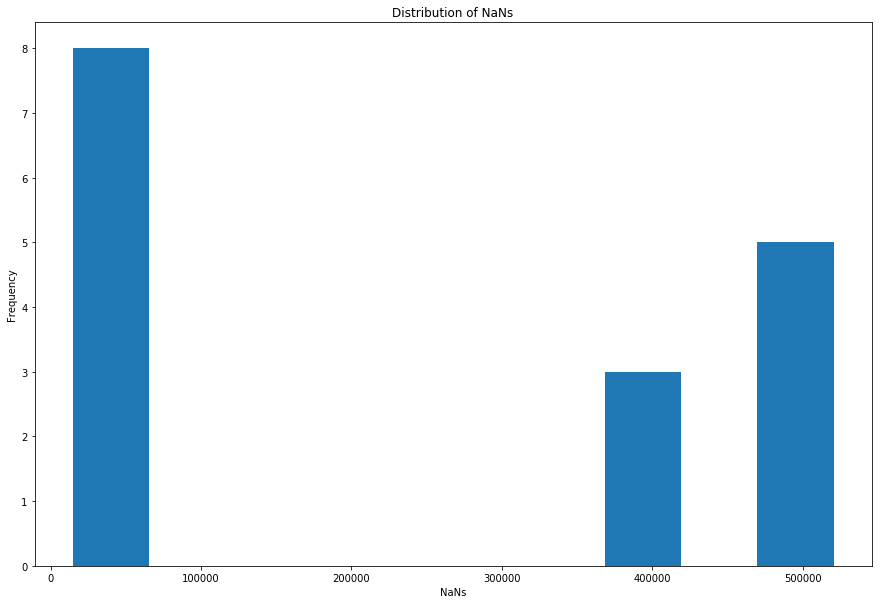

In [24]:
nutrition_facts_thresh_df.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

In [25]:
nutrition_facts_thresh_df.isnull().sum().sort_values()

energy_100g                                 14700
proteins_100g                               15950
fat_100g                                    17843
carbohydrates_100g                          17973
sugars_100g                                 27433
salt_100g                                   29240
sodium_100g                                 29281
saturated-fat_100g                          42171
additives_n                                389096
ingredients_from_palm_oil_n                389096
ingredients_that_may_be_from_palm_oil_n    389096
fiber_100g                                 489602
nova_group                                 498883
serving_quantity                           514771
nutrition-score-fr_100g                    520610
nutrition-score-uk_100g                    520610
dtype: int64

In [26]:
print ("We have now {} of samples with {} fields".format(nutrition_facts_thresh_df.shape[0],
                                                         nutrition_facts_thresh_df.shape[1]))

We have now 738255 of samples with 16 fields


We think that this is the optimal way to decrease the number of NaNs in this dataset. Putting the threshold higher then the selected value will delete the nutrition score columns. 

After dealing with the missing values, let's check the statistics of our data. 

### Lets look at the stats

In [27]:
nutrition_facts_thresh_df.describe()

,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,2.234840e+05,349159.000000,349159.000000,349159.000000,239372.000000,7.235550e+05,7.204120e+05,6.960840e+05,720282.00000,7.108220e+05,2.486530e+05,7.223050e+05,7.090150e+05,7.089740e+05,217645.000000,217645.000000
mean,1.446762e+02,1.618644,0.025696,0.066027,3.665140,9.212235e+36,2.601427e+01,1.171675e+01,30.01567,2.078074e+01,2.122561e+02,1.313906e+02,1.164393e+02,4.679614e+01,9.509251,9.291833
std,1.622487e+04,2.321812,0.160081,0.301313,0.772107,7.836115e+39,1.030830e+04,5.380194e+03,1013.10020,5.426413e+03,1.020974e+05,1.044948e+05,9.606399e+04,3.842717e+04,8.712979,9.203235
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.00000,-1.786000e+01,-6.700000e+00,-8.000000e+02,0.000000e+00,0.000000e+00,-15.000000,-15.000000
25%,2.800000e+01,0.000000,0.000000,0.000000,4.000000,4.390000e+02,5.700000e-01,1.000000e-01,3.57000,7.000000e-01,0.000000e+00,1.100000e+00,6.000000e-02,2.400000e-02,2.000000,1.000000
50%,4.300000e+01,1.000000,0.000000,0.000000,4.000000,1.117000e+03,6.900000e+00,1.900000e+00,15.80000,4.000000e+00,1.500000e+00,5.700000e+00,5.300000e-01,2.116000e-01,10.000000,10.000000
75%,1.100000e+02,2.000000,0.000000,0.000000,4.000000,1.674000e+03,2.143000e+01,7.500000e+00,54.00000,2.080000e+01,3.600000e+00,1.200000e+01,1.370000e+00,5.445760e-01,16.000000,17.000000
max,6.495676e+06,30.000000,3.000000,5.000000,4.000000,6.665559e+42,8.748748e+06,4.488758e+06,857855.00000,4.574988e+06,5.089889e+07,8.880858e+07,8.088869e+07,3.235548e+07,40.000000,40.000000


Well, It seems that there is no difference between the `nutrition-score-fr_100g` and `nutrition-score-uk_100g`. Let's analyse that. 

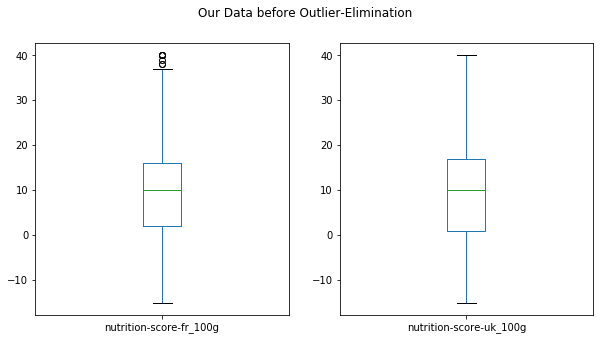

In [28]:
nutrition_facts_thresh_df[['nutrition-score-fr_100g','nutrition-score-uk_100g']].select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data before Outlier-Elimination', figsize=(10,5))

plt.show()

As expected, the two scores has the same distribution except some outliers in the `nutrition-score-fr_100g`.

In [29]:
nutrition_facts_thresh_df.head()

,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,
0000000000017,NaN,NaN,NaN,NaN,NaN,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.40,0.560,NaN,NaN
0000000000123,NaN,NaN,NaN,NaN,NaN,88.0,0.0,0.00,4.8,0.4,NaN,0.2,2.04,0.816,NaN,NaN
0000000000178,NaN,NaN,NaN,NaN,NaN,251.0,3.0,1.00,10.0,3.0,NaN,2.0,1.15,0.460,NaN,NaN
0000000000949,NaN,NaN,NaN,NaN,NaN,134.0,0.3,0.10,5.3,3.9,NaN,0.9,0.42,0.168,1.0,1.0
0000000000970,NaN,NaN,NaN,NaN,NaN,540.0,4.9,3.10,16.3,16.3,NaN,4.4,0.25,0.100,NaN,NaN


We clearly see a huge number of outliers in the dataset after looking to min,max,mean and standard deviation of each feature.
All the ingredient feature should have a resonable value <=100g except the energy which is expressed in Kj. 

### What about outliers in the row data?

First, the column `serving_quantity` is not an ingredient. It can be dropped 

In [30]:
nutrition_facts_thresh_df=nutrition_facts_thresh_df.drop(columns=['serving_quantity'])

In [31]:
# storing the columns fields in a list
fields=list(nutrition_facts_thresh_df.columns)

We rename the columns by replacing '-' by '_'. This will allow us to create the formula for the statsmodel regression since'-' is interpreted as a math operation while definiing the formula as a string. 

In [32]:
for field in fields: 
    nutrition_facts_thresh_df = nutrition_facts_thresh_df.rename(columns={field: field.replace('-','_')})
fields=nutrition_facts_thresh_df.columns

Let us now remove the outliers. All nutrition feautres should have a value <=100g (except energy_100g)

In [33]:
nutrition_facts_clean_df= nutrition_facts_thresh_df[(nutrition_facts_thresh_df
                                                      [nutrition_facts_thresh_df.columns.difference(['energy_100g'])] <= 100.0).all(1)]


Negative values can not be possible. Except for the nutrition score that is by definition defined between -14 and 40 

In [34]:

nutrition_facts_clean_df = nutrition_facts_clean_df[(nutrition_facts_clean_df[nutrition_facts_clean_df.columns.difference(['nutrition_score_fr_100g', 'nutrition_score_uk_100g'])] >= 0).all(1)]

In [35]:
"""
nutrition_facts_thresh_clean_df=nutrition_facts_thresh_df.copy()
for field in fields[:-1]: 
    #nutrition_facts_thresh_clean_df=nutrition_facts_thresh_clean_df[np.abs(nutrition_facts_thresh_df_zscore[field])<=3]
    nutrition_facts_thresh_clean_df=nutrition_facts_thresh_clean_df[np.abs(nutrition_facts_thresh_df[field]-nutrition_facts_thresh_df
                                                             [field].mean())<=(3*nutrition_facts_thresh_df[field].std())]
"""

'\nnutrition_facts_thresh_clean_df=nutrition_facts_thresh_df.copy()\nfor field in fields[:-1]: \n    #nutrition_facts_thresh_clean_df=nutrition_facts_thresh_clean_df[np.abs(nutrition_facts_thresh_df_zscore[field])<=3]\n    nutrition_facts_thresh_clean_df=nutrition_facts_thresh_clean_df[np.abs(nutrition_facts_thresh_df[field]-nutrition_facts_thresh_df\n                                                             [field].mean())<=(3*nutrition_facts_thresh_df[field].std())]\n'

In [36]:
print("We have only {} rows left".format(nutrition_facts_clean_df.shape[0]))

We have only 64891 rows left


We lost a huge number of rows by removing the outliers. The dataset is highly corrupted in terms of ingredients.  We are going to see later if this number of samples is enough to have significant results. 

In [37]:
nutrition_facts_clean_df.head(10)

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
code,,,,,,,,,,,,,,,
0000000005470,3.0,0.0,0.0,4.0,669.0,2.20,0.50,25.20,0.60,1.6,9.50,0.35800,0.143200,-4.0,-4.0
0000000043595,0.0,0.0,0.0,3.0,1255.0,0.00,0.00,83.33,66.67,10.0,0.00,0.00000,0.000000,3.0,3.0
0000000274722,2.0,0.0,0.0,4.0,450.0,2.20,0.90,15.30,0.50,0.5,6.80,0.70000,0.280000,0.0,0.0
0000000491228,4.0,0.0,2.0,4.0,1952.4,15.30,11.20,75.50,69.80,0.1,6.80,0.50000,0.200000,2.0,2.0
0000010206515,5.0,0.0,2.0,4.0,1720.0,6.42,3.53,87.86,81.67,0.0,0.03,0.10000,0.040000,18.0,18.0
0000020043131,0.0,0.0,0.0,3.0,1527.0,1.18,0.00,71.76,4.71,2.4,12.94,1.19634,0.478536,3.0,3.0
0000020045791,2.0,0.0,0.0,3.0,1749.0,21.76,5.29,51.76,32.94,2.4,5.88,0.67310,0.269240,17.0,17.0
0000020047825,0.0,0.0,1.0,3.0,1623.0,22.35,11.76,42.35,15.29,2.4,4.71,0.80772,0.323088,18.0,18.0
0000030053014,2.0,0.0,0.0,4.0,1046.0,0.00,0.00,95.00,0.00,0.0,0.00,0.00000,0.000000,3.0,3.0


We lost a huge number of rows but the dataset is now very clean !! 

## Impact of the ingredients on the nutrition score

Before analyzing the impact of our variables on the nutrition score, we need to normalize our data by removing the mean and dividng by the standard deviation 

In [38]:
nutrition_facts_clean_df = nutrition_facts_clean_df.select_dtypes(include=float).transform(lambda x: (x - x.mean()) / x.std())

We can check now if the mean of our variables is close to zero and the standard deviation is close to 1. 

In [39]:
nutrition_facts_clean_df.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
count,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04,6.489100e+04
mean,1.768336e-15,6.829945e-14,-3.820820e-14,-1.328398e-14,2.914834e-16,2.186326e-14,-2.164904e-14,-1.285425e-14,4.716969e-15,2.749954e-15,-3.084354e-15,1.840389e-14,-6.506366e-14,-1.311135e-15,1.278114e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.606263e-01,-2.108649e-01,-2.680268e-01,-2.382183e+00,-1.422832e+00,-7.807819e-01,-6.320223e-01,-1.127199e+00,-7.446427e-01,-6.544841e-01,-9.271591e-01,-3.663600e-01,-3.636796e-01,-2.601862e+00,-2.480634e+00
25%,-7.606263e-01,-2.108649e-01,-2.680268e-01,-3.612624e-01,-9.063574e-01,-7.266425e-01,-6.184157e-01,-8.783783e-01,-6.720748e-01,-6.544841e-01,-7.245593e-01,-3.346414e-01,-3.333766e-01,-7.849687e-01,-8.278836e-01
50%,-3.165695e-01,-2.108649e-01,-2.680268e-01,6.491979e-01,-1.051920e-01,-4.048141e-01,-4.143160e-01,-3.920467e-01,-4.766995e-01,-2.712374e-01,-2.271587e-01,-1.544486e-01,-1.553469e-01,9.922202e-03,-1.667836e-01
75%,5.715441e-01,-2.108649e-01,-2.680268e-01,6.491979e-01,6.934541e-01,4.223149e-01,2.183930e-01,9.048375e-01,3.483425e-01,2.078209e-01,2.860132e-01,8.395172e-02,8.274321e-02,8.048131e-01,8.248663e-01
max,9.896737e+00,9.404899e+00,1.280120e+01,6.491979e-01,2.213597e+01,5.234702e+00,1.297462e+01,2.642813e+00,4.837509e+00,2.329843e+01,1.108325e+01,3.747496e+01,3.751498e+01,3.643709e+00,3.359083e+00


Great! our data is now ready for the analysis on the impact of our variables on the nutrition score.

Before doing so, let's see the correlation between variables visualized in a heatmap.

### Variable correlations 

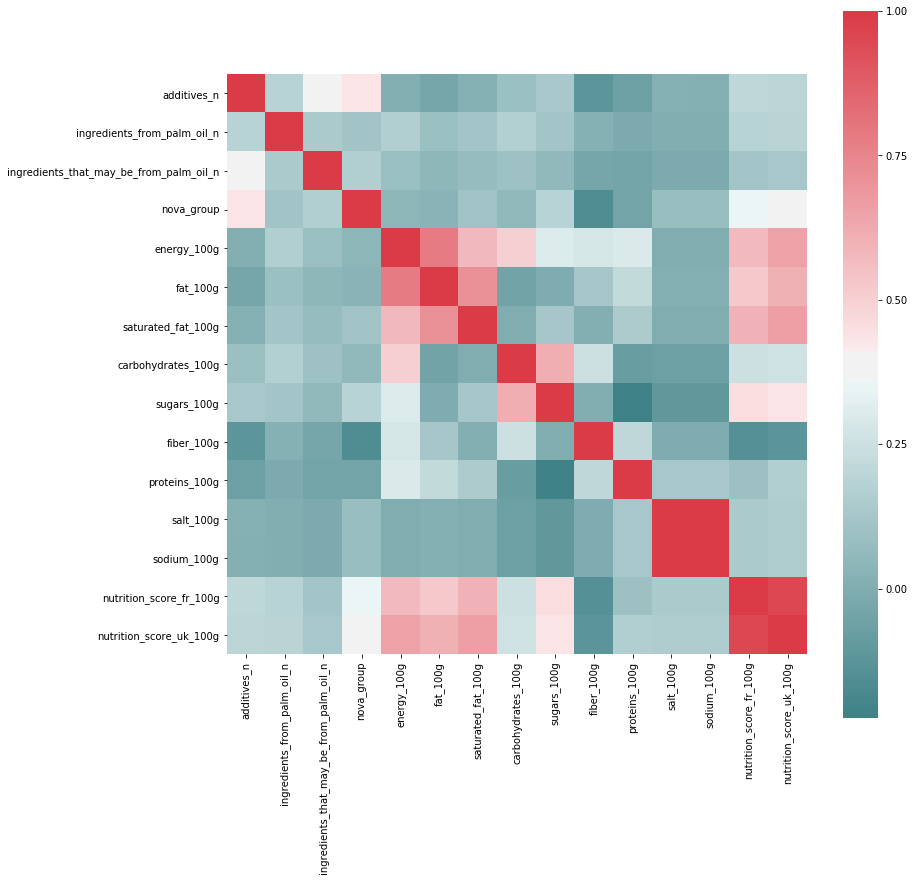

In [40]:
correlation_variables = nutrition_facts_clean_df.corr(method = "pearson")

f, ax = plt.subplots(figsize=(13, 13))

sns.heatmap(correlation_variables, mask=np.zeros_like(correlation_variables, dtype=np.bool),cmap=sns.diverging_palette(200, 10, as_cmap=True), square=True, ax=ax)

From the plot of correlation above we can confirm first that `nutrition_score_fr_100g` and `nutrition_score_uk_100g` are nearly the same.    
We can see also a  correlation equal to 1 between `sodium_100g` and `salt_100g`. This is why we will drop the column `sodium_100g` to avoid redundancy. 

In [41]:
#We drop sodium column. 
nutrition_facts_clean_df=nutrition_facts_clean_df.drop(columns=['sodium_100g'])
fields_left=nutrition_facts_clean_df.columns

In [42]:
#We drop one of the nutrition scores 
nutrition_facts_clean_df=nutrition_facts_clean_df.drop(columns=['nutrition_score_uk_100g'])


In [43]:
nutrition_facts_clean_df=nutrition_facts_clean_df.drop(columns=["ingredients_from_palm_oil_n","ingredients_that_may_be_from_palm_oil_n"])


In [57]:
fields_left=nutrition_facts_clean_df.columns

Let's see the heatmap again. 

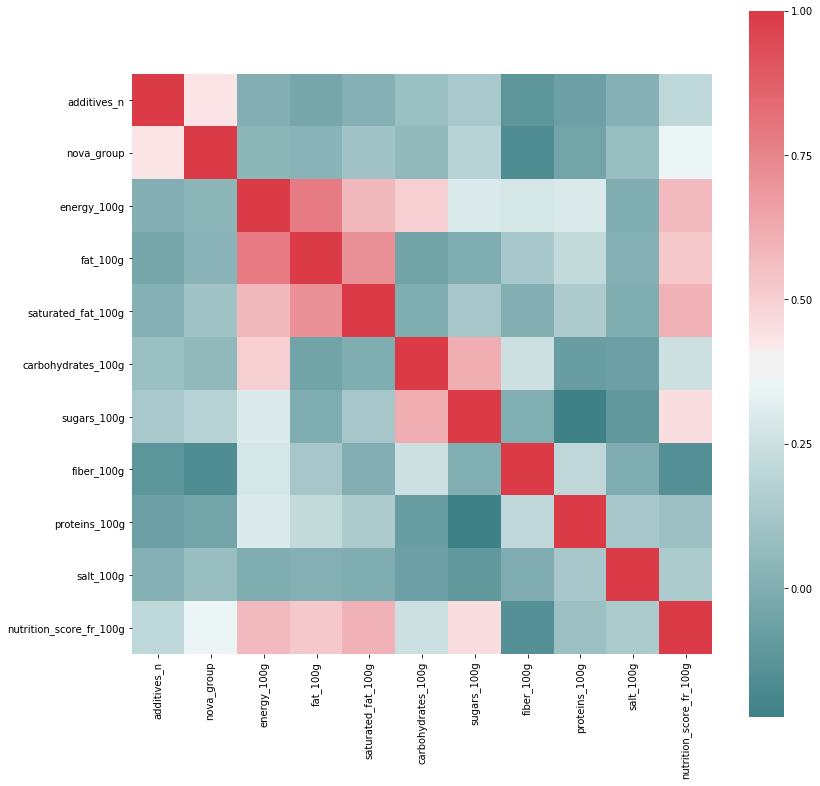

In [44]:
#calculating pearson correlation
correlation_variables = nutrition_facts_clean_df.corr(method = "pearson")

f, ax = plt.subplots(figsize=(13, 13))

#we draw the heatmap using seaborn
sns.heatmap(correlation_variables, mask=np.zeros_like(correlation_variables, dtype=np.bool),cmap=sns.diverging_palette(200, 10, as_cmap=True), square=True, ax=ax)

By looking at the heatmap, we can already predict that `energey_100g`, `fat_100g`, `saturated_fat_100g` and `sugar_100g` have the highest correlation on the nutrition score.


Now everything is ready. What we want to do is to find the impact of each ingredient on the nutrition score. One way to do that is a regression. It allows us to see the impact of each variable on this score by looking to the weights. 

## Regression

### Using Ridge regression 

We split first the data to training and testing 

In [46]:
#let's split the dataset to training and testign
test_size = 0.2
train_df, test_df = train_test_split(nutrition_facts_clean_df, test_size=test_size)
print('Size of the training set: {}\t({:.2f}%)'.format(len(train_df),len(train_df)/len(nutrition_facts_clean_df)*100))
print('Size of the testing set: {}\t({:.2f}%)'.format(len(test_df),len(test_df)/len(nutrition_facts_clean_df)*100))

Size of the training set: 51912	(80.00%)
Size of the testing set: 12979	(20.00%)


In [47]:
def generate_train_test_arrays(train_df, test_df):
    ''' 
    Converts provided DataFrame objects to numpy arrays. 
    The Ridge regression requires this format to work. 
    The DataFrames should contain the training and testing
    samples respectively. 
    
    Returns following numpy arrays:
        X_train, y_train, X_test, y_test
    '''
    
    # Prepare the data for the regression
    y_train = train_df.loc[:, 'nutrition_score_fr_100g'].values                 # shape is [n_sample]
    X_train= train_df.drop(columns=['nutrition_score_fr_100g']).to_numpy()
    y_test= test_df.loc[:, 'nutrition_score_fr_100g'].values                 # shape is [n_sample]
    X_test= test_df.drop(columns=['nutrition_score_fr_100g']).to_numpy()
    
    return X_train, y_train, X_test, y_test

In [48]:
X_train, y_train, X_test, y_test = generate_train_test_arrays(train_df, test_df)

#We create a list containing the alpha values we are going to test
alphas=list(range(0,1000,1))

#Gridsearch with only on parameter
param_grid = {'alpha':alphas}

The ridge regression has one hyper-parameter which is $\alpha$. Let us tune it using 5-fold crossvalidation

In [49]:
# Let's start optimizing our hyper parameter alpha using 5-fold Cross validation, We put the flag 
print("# Tuning hyper-parameter alpha\n")
clf = GridSearchCV(Ridge(normalize=False), param_grid, cv=5,
                   scoring='neg_mean_squared_error')
clf.fit(X_train,y_train)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

#printing the best alpha found
best_alpha = clf.best_params_['alpha']
print('Best alpha:',best_alpha)

# Tuning hyper-parameter alpha

Best alpha: 230


After tuning our hyper-parameter, we train our ridge regression.

In [65]:
ridge     = Ridge(alpha=best_alpha,     normalize=False)

# Fit the estimators
ridge.fit(X_train, y_train)

# Predict on the test set
y_pred     = ridge.predict(X_test)

print("Testing MSE = ",((y_test - y_pred)**2).mean())

Testing MSE =  0.3401732809209511


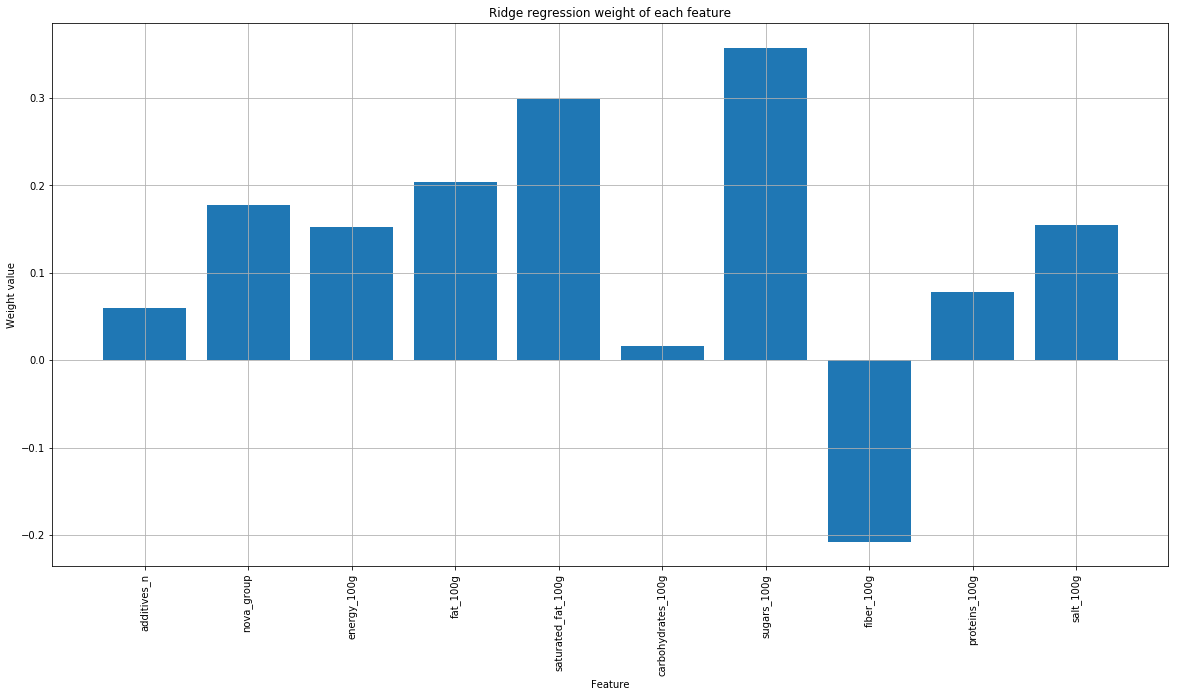

In [60]:
# Let us retrain the model with alpha = 230
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train,y_train)

# Plot the regression's weights 

plt.figure(figsize=(20,10))
plt.bar(fields_left[:-1],ridge.coef_)
plt.xticks(rotation=90)
plt.title('Ridge regression weight of each feature')
plt.xlabel('Feature')
plt.ylabel('Weight value')
plt.grid()

* positive coef : 

1) sugars_100g     
2) saturated_fat_100g  
3) fat_100g  
4) Nova_group  
5) salt_100g  
6) energy_100g  
7) proteins_100g  
8) additive_n    

* Negative coef: 
fiber_100g 

### Ordinary least square regression using statsmodel

Let's prepare our formula for the regression: 

In [61]:
nutrition_facts_clean_df.head()

,additives_n,nova_group,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,nutrition_score_fr_100g
code,,,,,,,,,,,
0000000005470,0.571544,0.649198,-0.580097,-0.648441,-0.563989,-0.177156,-0.711150,-0.271237,0.225355,-0.230888,-1.352748
0000000043595,-0.760626,-0.361262,0.158084,-0.780782,-0.632022,2.014352,2.976978,1.740808,-0.927159,-0.366360,-0.557857
0000000274722,0.127487,0.649198,-0.855970,-0.648441,-0.509563,-0.550387,-0.716732,-0.534720,-0.102202,-0.101471,-0.898525
0000000491228,1.015601,0.649198,1.036595,0.139587,0.891922,1.719160,3.151699,-0.630531,-0.102202,-0.177153,-0.671413
0000010206515,1.459658,0.649198,0.743842,-0.394588,-0.151708,2.185134,3.814300,-0.654484,-0.923520,-0.328519,1.145481


In [62]:
fields_left=nutrition_facts_clean_df.columns
formula_string="nutrition_score_fr_100g ~ "
for field in fields_left[:-2]:
    formula_string=formula_string+field+"+"
formula_string=formula_string[:-1]
formula_string

'nutrition_score_fr_100g ~ additives_n+nova_group+energy_100g+fat_100g+saturated_fat_100g+carbohydrates_100g+sugars_100g+fiber_100g+proteins_100g'

In [63]:
nutrition_score_regression = sm.ols(formula= formula_string, data = nutrition_facts_clean_df)
res = nutrition_score_regression.fit()
print(res.summary())

                               OLS Regression Results                              
Dep. Variable:     nutrition_score_fr_100g   R-squared:                       0.653
Model:                                 OLS   Adj. R-squared:                  0.653
Method:                      Least Squares   F-statistic:                 1.356e+04
Date:                     Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                             14:46:09   Log-Likelihood:                -57749.
No. Observations:                    64891   AIC:                         1.155e+05
Df Residuals:                        64881   BIC:                         1.156e+05
Df Model:                                9                                         
Covariance Type:                 nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

Analysing the regression results from the coeficents of each ingredient, we can deduce the impact of these ingredients on the the nutrition score.  

#### Positive coef 
* `sugars_100g` has the highest positive impact nutrition score ~ 0.35  
* `saturated_fat_100g`has the fourth highest impact on nutrition socre ~ 0,3
* `nova_group`with a coef ~ 0.2
* `fat_100g` with a coef ~ 0.19
* `energy_100` has the second highest nutrition score ~ 0.18 



#### Negative coef 
* `fiber_100g` has the highest negative nutrition score ~-0.2 

From the french nutrition score datasheet page 24, we see that the highest the nutrition score is the lowest the nutritional quality is. We can then deduce that all products with a high percentage of energy, sugar, salt, and saturated fat all unhealthy and products with a high percentage of fiber are healthy. All other ingredients do not have a huge impact on the nutrition score.  
By analyzing the p-value we can deduce that our variables are statistically significant except the `carbohydrate_100g`.    
The number of samples we have in hand after dropping the outliers and NaNs is enough to have significant results.

One of the features which seems to have a high impact on the nutrition score is the nova group. The values of this group are {1,2,3,4}

* Group 1 - Unprocessed or minimally processed foods :Unprocessed (or natural) foods are edible parts of plants (seeds, fruits, leaves, stems, roots) or of animals (muscle, offal, eggs, milk), and also fungi, algae and water, after separation from nature.
* Group 2 - Processed culinary ingredients : Processed culinary ingredients, such as oils, butter, sugar and salt, are substances derived from Group 1 foods or from nature by processes that include pressing, refining, grinding, milling and drying.
* Group 3 - Processed foods : Processed foods, such as bottled vegetables, canned fish, fruits in syrup, cheeses and freshly made breads, are made essentially by adding salt, oil, sugar or other substances from Group 2 to Group 1 foods. 
* Group 4 - Ultra-processed food and drink products: Ultra-processed foods, such as soft drinks, sweet or savoury packaged snacks, reconstituted meat products and pre-prepared frozen dishes.  

Beeing in a higher group leads also to a high nutrition score and then low nutritional quality.  